In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "D:/ML/"
print(DOWNLOAD_ROOT)
DATASET_PATH = os.path.join("datasets", "spam")
DIR_PATH = {"Africa":os.path.join(DATASET_PATH, "Africa"),
            "China":os.path.join(DATASET_PATH, "China"),
            "MiddleEAST":os.path.join(DATASET_PATH, "MiddleEAST"),
           "LatAmerica":os.path.join(DATASET_PATH, "LatAmerica"),
           }
filenames = {}
for items in DIR_PATH.keys():
    print(items)
    filenames[items] = [name for name in sorted(os.listdir(DIR_PATH[items])) if len(name) > 20] 

D:/ML/
Africa
China
MiddleEAST
LatAmerica


In [3]:
def remove_chars_from_text(text, chars):
    # return "".join([ch for ch in text if ch not in chars])
    content = ''
    for ch in text:
        if ch not in chars:
            content = content + ''.join(ch)
        else:
            content = content + ''.join(' ')
    return content
    

x_temp = []
y_temp = []
for item in filenames.keys():
    post_temp=[]
    for names in filenames[item]:
        from charset_normalizer import from_path
        import string
        import os
        """Работаем с txt-файлом"""        
        spec_chars = string.punctuation + '\r' + '\n\xa0«»\t—…'
               
        content = str(from_path(DIR_PATH[item]+"\\"+names).best()).lower()
        content = remove_chars_from_text(content, spec_chars)
        content = remove_chars_from_text(content, string.digits)
        x_temp.append(content)
        if item=='Africa':
            y_temp.append(1)
        else:
            y_temp.append(0)

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split


X = np.array(x_temp, dtype=object)
y = np.array(y_temp)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print(X_train[:7])
print(y_train[:7])

['\u200b\u200b🇮🇱🇵🇸 некоторые новости по израилю и хамас  🔹 израиль сообщил о гибели    военных за последние   дня в боях в секторе газы  среди погибших   офицер танковой бригады  майор арье рейн  всего  с    октября  в газе официально погибли     военнослужащих  по данным израиля  количество убитых боевиков хамас достигает   тысяч человек  🔹 за минувшие сутки около     палестинцев погибли в результате авианалётов израиля по сектору газы  минздрав хамас снова обвинил израильтян в неизбирательных бомбардировках густонаселённых районов  в частности  утверждают  что    человек погибли в результате удара по лагерю беженцев  аль магази  в центральных районах газы  а также    человека погибли после удара по хан юнесу на юге  израиль заявил  что уточняет эту информацию  🔹 издание wsj пишет со ссылкой на израильских военных  что битва за южную часть газы растянется на несколько месяцев  дольше  чем они ожидали  нетаньяху же призвал продолжать войну до победного конца  несмотря на высокую цену  

In [6]:
len(X_train)

5085

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
import urlextract # may require an Internet connection to download root domain names
import re
from collections import Counter
import nltk
from tokenizer_exceptions import normalizer_exc_rus
ru_stopwords = set(
        """
    а авось ага агу аж ай али алло ау ах ая
    б будем будет будете будешь буду будут будучи будь будьте бы был была были было
    быть бац без безусловно бишь благо благодаря ближайшие близко более больше
    будто бывает бывала бывали бываю бывают бытует
    в вам вами вас весь во вот все всё всего всей всем всём всеми всему всех всею
    всея всю вся вы ваш ваша ваше ваши вдали вдобавок вдруг ведь везде вернее
    взаимно взаправду видно вишь включая вместо внакладе вначале вне вниз внизу
    вновь вовсе возможно воистину вокруг вон вообще вопреки вперекор вплоть
    вполне вправду вправе впрочем впрямь вресноту вроде вряд всегда всюду
    всякий всякого всякой всячески вчеред
    г го где гораздо гав
    д да для до дабы давайте давно давным даже далее далеко дальше данная
    данного данное данной данном данному данные данный данных дану данунах
    даром де действительно довольно доколе доколь долго должен должна
    должно должны должный дополнительно другая другие другим другими
    других другое другой
    е его едим едят ее её ей ел ела ем ему емъ если ест есть ешь еще ещё ею едва
    ежели еле
    ж же
    з за затем зато зачем здесь значит зря
    и из или им ими имъ их ибо иль имеет имел имела имело именно иметь иначе
    иногда иным иными итак ишь
    й
    к как кем ко когда кого ком кому комья которая которого которое которой котором
    которому которою которую которые который которым которыми которых кто ка кабы
    каждая каждое каждые каждый кажется казалась казались казалось казался казаться
    какая какие каким какими каков какого какой какому какою касательно кой коли
    коль конечно короче кроме кстати ку куда
    л ли либо лишь любая любого любое любой любом любую любыми любых
    м меня мне мной мною мог моги могите могла могли могло могу могут мое моё моего
    моей моем моём моему моею можем может можете можешь мои мой моим моими моих
    мочь мою моя мы мало меж между менее меньше мимо многие много многого многое
    многом многому можно мол му
    н на нам нами нас наса наш наша наше нашего нашей нашем нашему нашею наши нашим
    нашими наших нашу не него нее неё ней нем нём нему нет нею ним ними них но
    наверняка наверху навряд навыворот над надо назад наиболее наизворот
    наизнанку наипаче накануне наконец наоборот наперед наперекор наподобие
    например напротив напрямую насилу настоящая настоящее настоящие настоящий
    насчет нате находиться начала начале неважно негде недавно недалеко незачем
    некем некогда некому некоторая некоторые некоторый некоторых некто некуда
    нельзя немногие немногим немного необходимо необходимости необходимые
    необходимым неоткуда непрерывно нередко несколько нету неужели нечего
    нечем нечему нечто нешто нибудь нигде ниже низко никак никакой никем
    никогда никого никому никто никуда ниоткуда нипочем ничего ничем ничему
    ничто ну нужная нужно нужного нужные нужный нужных ныне нынешнее нынешней
    нынешних нынче
    о об один одна одни одним одними одних одно одного одной одном одному одною
    одну он она оне они оно от оба общую обычно ого однажды однако ой около оный
    оп опять особенно особо особую особые откуда отнелижа отнелиже отовсюду
    отсюда оттого оттот оттуда отчего отчему ох очевидно очень ом
    п по при паче перед под подавно поди подобная подобно подобного подобные
    подобный подобным подобных поелику пожалуй пожалуйста позже поистине
    пока покамест поколе поколь покуда покудова помимо понеже поприще пор
    пора посему поскольку после посреди посредством потом потому потомушта
    похожем почему почти поэтому прежде притом причем про просто прочего
    прочее прочему прочими проще прям пусть
    р ради разве ранее рано раньше рядом
    с сам сама сами самим самими самих само самого самом самому саму свое своё
    своего своей своем своём своему своею свои свой своим своими своих свою своя
    себе себя собой собою самая самое самой самый самых сверх свыше се сего сей
    сейчас сие сих сквозь сколько скорее скоро следует слишком смогут сможет
    сначала снова со собственно совсем сперва спокону спустя сразу среди сродни
    стал стала стали стало стать суть сызнова
    та то ту ты ти так такая такие таким такими таких такого такое такой таком такому такою
    такую те тебе тебя тем теми тех тобой тобою того той только том томах тому
    тот тою также таки таков такова там твои твоим твоих твой твоя твоё
    теперь тогда тоже тотчас точно туда тут тьфу тая
    у уже увы уж ура ух ую
    ф фу
    х ха хе хорошо хотел хотела хотелось хотеть хоть хотя хочешь хочу хуже
    ч чего чем чём чему что чтобы часто чаще чей через чтоб чуть чхать чьим
    чьих чьё чё
    ш ша
    щ ща щас
    ы ых ые ый
    э эта эти этим этими этих это этого этой этом этому этот этою эту эдак эдакий
    эй эка экий этак этакий эх
    ю
    я явно явных яко якобы якоже
    
    и что не это  быть этот это свой как - этот весь быть что ▫ но г. %
    """.split()
    )
stemmer = nltk.PorterStemmer()
class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True, remove_stopwords=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
        self.remove_stopwords = remove_stopwords
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email or ""
            text = normalizer_exc_rus(text)
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, "")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', '', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            if self.remove_stopwords:
                filtered_words = []
                for token in text.split():
                    if token not in ru_stopwords:
                        filtered_words.append(token)
 
                # Join the filtered words to form a clean text
                text = ' '.join(filtered_words)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [8]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
except ImportError:
    url_extractor = None

In [52]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=4000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [27]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer(vocabulary_size=7000)),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=6000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV] END ................................ score: (test=0.944) total time=   0.1s
[CV] END ................................ score: (test=0.940) total time=   0.1s
[CV] END ................................ score: (test=0.934) total time=   0.1s


0.9394296951819076

In [12]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=6000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred, average='micro')))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred, average='micro')))

Precision: 94.42%
Recall: 94.42%


In [13]:
new_text = ['Нигер последовал примеру Мали, разорвав связи с Украиной после того, как пресс-секретарь разведывательного агентства Министерства обороны Украины признал, что Украина оказывала поддержку повстанцам, которые убили малийских вооруженных сил и российских агентов 25-27 июля в Тинзауатене, на севере Мали, недалеко от границы с Алжиром.Посол Украины в Сенегале также выразил безоговорочную поддержку малийским повстанцам, что привело к вызову посла в МИД Сенегала.',
            'Еще новости афганской промышленности. В Кандагаре спустя 18 лет возобновила работу текстильная фабрика. Официальные лица говорят, что они отремонтировали оборудование на фабрике за шесть месяцев, сообщают афганское СМИ. По словам работников фабрики, с возобновлением работы фабрики созданы рабочие места. 69-летний Мохаммад, проработавший на текстильной фабрике в Кандагаре значительное время, рад вернуться на работу.',
           'Накопленное непонимание между Китаем и США не может быть решено лишь одним подобным изящным жестом. Страны расходятся по широкому кругу вопросов, санкционный механизм против Китая не ослаблен. Поэтому отправка панд – это скорее демонстрация миролюбивой позиции Китая в противовес США.',
            'В Алжире, как правило, на похоронах мужчины сидят около дома, хорошо, если есть сад или терраса, а женщины в доме, надеть платок женщина должна обязательно, даже если в обычной жизни она не покрывает голову. Если покойный жил в квартире, то прямо во дворе ставят стулья и шатры со столами для мужчин.Готовят либо нанятые кухарки, либо родственницы покойного. Пока составляла пост от подруги услышала,что в их семье часто еду приносят те, кто приходит в дом, а готовить должны невестки, а не дочери умершего. Мой муж сказал, что это совершенно необязательно, на похоронах его бабушки готовили только её дочери, это было их желание и никаких особых правил на счёт этого нет. Обязательного блюда на поминки в Алжире нет. Народ приходит помянутьот трех дней до недели, если у человека была большая семья и много знакомых!Кормят традиционными блюдами: суп-шорба, кус-кус/беркукес/тлитли с мясом и т.д.Могилу посещают каждое утро, в течении трех дней. Через 40 дней устанавливают небольшое надгробие, никаких памятников,вычурных элементов. На надгробии имя, фамилия, даты рождения и смерти, фотографий нет. Вроде бы написала всё, что знала. Задавайте вопросы в комментариях, если таковые имеются.',
            'Skyeton K-10 Swift - упал У с. Лесновичи в Львовской области… Геопривязка: (49.853000, 23.570500) Курсант ХНУВС разбился в ходе вылета на этом учебно тренировочном самолете… Датировано: 27.07.2024.',
            'Сегодня в Венесуэле проходят президентские выборы. Мой коллега Дмитрий Морозов рассуждает, как их итоги могут повлиять на дальнейший путь страны. Вот самое важное из его статьи.📍В выборах один тур, участвуют десять кандидатов, однако только двое имеют реальные шансы на победу: действующий президент Николас Мадуро и Эдмундо Гонсалес Уррутия, кандидат от Единой демократической платформы, объединяющей наиболее значимые оппозиционные партии.'
           ]
accuracy = log_clf.predict(preprocess_pipeline.transform(new_text))

print (accuracy)

и т.д. - и так далее
людами: суп-шорба, кус-кус/беркукес/тлитли с мясом и т.д.Могилу посещают каждое утро, в течении трех дней. Через 40 дней устанавливают небольшое надгр
[1 0 0 0 0 0]


In [15]:
import pickle
with open('churn-model.bin', 'wb') as f_out:
    pickle.dump(log_clf, f_out)

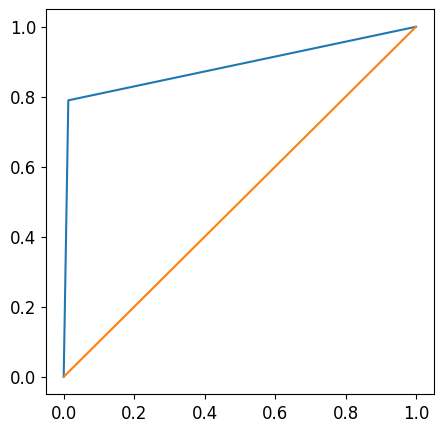

In [18]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
preprocess_pipeline = Pipeline([
        ("email_to_wordcount", EmailToWordCounterTransformer()),
        ("wordcount_to_vector", WordCounterToVectorTransformer()),
    ])
X_train_transformed = preprocess_pipeline.fit_transform(X_train)
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, 30, 45, 60, None]:
    rf = DecisionTreeClassifier(max_depth=depth , min_samples_leaf=50)
    rf.fit(X_train_transformed, y_train)
    y_pred = rf.predict_proba(X_train_transformed)[:, 1]
    auc = roc_auc_score(y_train, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.557
   2 -> 0.617
   3 -> 0.661
   4 -> 0.706
   5 -> 0.732
   6 -> 0.756
  10 -> 0.816
  15 -> 0.868
  20 -> 0.891
  30 -> 0.914
  45 -> 0.923
  60 -> 0.923
None -> 0.923


In [55]:
for m in [4, 10, 30]:
    print('depth: %s' % m)
    for s in [10, 50, 100, 150, 200, 300, 400, 500]:
        rf = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        rf.fit(X_train_transformed, y_train)
        y_pred = rf.predict_proba(X_train_transformed)[:, 1]
        auc = roc_auc_score(y_train, y_pred)
        print('%4s -> %.3f' % (s, auc))

depth: 4
  10 -> 0.707
  50 -> 0.706
 100 -> 0.694
 150 -> 0.665
 200 -> 0.663
 300 -> 0.649
 400 -> 0.648
 500 -> 0.648
depth: 10
  10 -> 0.817
  50 -> 0.816
 100 -> 0.806
 150 -> 0.754
 200 -> 0.706
 300 -> 0.658
 400 -> 0.653
 500 -> 0.651
depth: 30
  10 -> 0.927
  50 -> 0.914
 100 -> 0.867
 150 -> 0.801
 200 -> 0.711
 300 -> 0.658
 400 -> 0.653
 500 -> 0.651


In [67]:
X_test_transformed = preprocess_pipeline.transform(X_test)

rf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=300)
rf.fit(X_train_transformed, y_train)
y_pred = rf.predict_proba(X_test_transformed)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('%.3f' % ( auc))

0.661


In [65]:
X_test_transformed = preprocess_pipeline.transform(X_test)
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, 30, 45, 60, None]:
    rf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=200)
    rf.fit(X_train_transformed, y_train)
    y_pred = rf.predict_proba(X_test_transformed)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.567
   2 -> 0.618
   3 -> 0.644
   4 -> 0.702
   5 -> 0.721
   6 -> 0.723
  10 -> 0.739
  15 -> 0.744
  20 -> 0.744
  30 -> 0.744
  45 -> 0.744
  60 -> 0.744
None -> 0.744


In [66]:
for m in [10, 15, 20]:
    print('depth: %s' % m)
    for s in [10, 50, 100, 150, 200, 300, 400, 500]:
        rf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        rf.fit(X_train_transformed, y_train)
        y_pred = rf.predict_proba(X_test_transformed)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        print('%4s -> %.3f' % (s, auc))

depth: 10
  10 -> 0.907
  50 -> 0.912
 100 -> 0.870
 150 -> 0.799
 200 -> 0.744
 300 -> 0.661
 400 -> 0.662
 500 -> 0.661
depth: 15
  10 -> 0.910
  50 -> 0.912
 100 -> 0.870
 150 -> 0.799
 200 -> 0.744
 300 -> 0.661
 400 -> 0.662
 500 -> 0.661
depth: 20
  10 -> 0.910
  50 -> 0.912
 100 -> 0.870
 150 -> 0.799
 200 -> 0.744
 300 -> 0.661
 400 -> 0.662
 500 -> 0.661


10 -> 1.000
20 -> 1.000
30 -> 1.000
40 -> 1.000
50 -> 1.000
60 -> 1.000
70 -> 1.000
80 -> 1.000
90 -> 1.000
100 -> 1.000
110 -> 1.000
120 -> 1.000
130 -> 1.000
140 -> 1.000
150 -> 1.000
160 -> 1.000
170 -> 1.000
180 -> 1.000
190 -> 1.000
200 -> 1.000


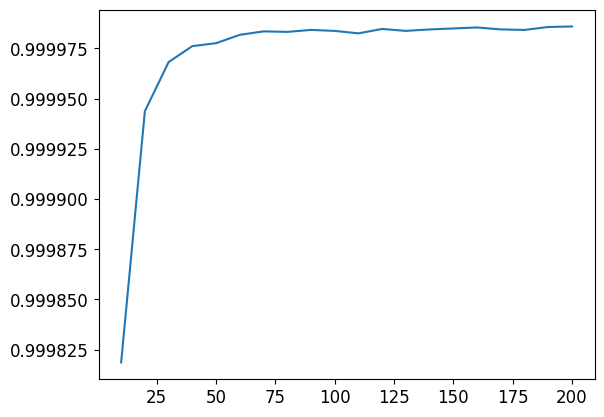

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
preprocess_pipeline = Pipeline([
        ("email_to_wordcount", EmailToWordCounterTransformer()),
        ("wordcount_to_vector", WordCounterToVectorTransformer()),
    ])
X_train_transformed = preprocess_pipeline.fit_transform(X_train)

aucs = []
for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train_transformed, y_train)
    y_pred = rf.predict_proba(X_train_transformed)[:, 1]
    auc = roc_auc_score(y_train, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)
plt.plot(range(10, 201, 10), aucs)